# Meta-Analysis of Allergy Genome-Wide Association Studies

## Supplementary Notebook

### Data Collection

I obtained my dataset from the [GWAS Catalog](https://www.ebi.ac.uk/gwas/). It has lots of data available for many different traits. I started by identifying the traits related to allergic disease that the GWAS Catalog had data for. The traits included allergic rhinitis, atopic eczema, atopy, peanut allergy, along with several others. 

The GWAS Catalog had individual csv files for many of these traits, so I was able to download them all and then merge them. However, I had to scrape the GWAS Catalog using its '/associations' API endpoint to obtain the data for some traits. The web scraping results were very different from the csv files so I had to modify the dataframe generated from the csv files so that they had the same format. This involved renaming columns, splitting columns into multiple columns, removing extra spaces and breaks, and modifying a few data types. __I have detailed this process (with code) in the Data Collection section of the Appendix.__

### Data Cleaning

During the data cleaning process, I handled each column (feature) independently. I started by analyzing the unique values to identify if any data was incorrectly reported. Then I checked the type of each column to determine if it would be helpful to convert it to a different type. I also checked the number of missing values and how they were repesented. They were repesented in several different ways including NaN, blank spaces, hyphens, so I processed these values to create some consistency among missing values. __I haved detailed the steps for specific columns below and have included the code in the Data Cleaning section of the Appendix.__

First, I started with the BETA column. There were 20 entries with NA values, and these rows had missing values for several of the other columns, so I decided to completely remove them. The general format of this column was a number followed by increase or decrease, so the entries were strings. I planned to use this column for quantitative analyses, so I have to convert it to a number. I chose to represent increases as positive numbers and decreases as negative numbers, which follows the convention used for the OR (odds ratio) column. To do this conversion, I split the split into two parts (number and increase/decrease), and then multiplied the number by -1 if the second part was decrease. I detected missing values by identifying if increase or decrease was included, and set missing values to -10. I chose -10 as opposed to 0 or -1 because other columns use those values (OR - odds ratio and NUM_MAPPED_GENES). The final BETA column comprised of floats.

Next, I moved onto the RAF column. The cleaning in this section pertained to type mismatches. The column consisted of ints, floats, strings that were numeric (ex: "15"), and strings that were not numeric (ex: "hello"). I went through the entire column to convert each type to a number. If the value was an int or float, I kept it the same. If it was a numeric string, I converted it to a float. If it wasn't a numeric string it was a missing value, so I represented it with -10. The final RAF column comprised of ints and floats.

Next, I processed the PVALUE column. I had to modify the representation of scientific notation in this column. The values were presented as strings with the general format: float + x + 10 + - + int (ex: "8 x 10-8"). To convert this to a float, I parsed each string and extracted the base (number before x) and the exponent (number after -). I then used multiplation and exponentiation to calculate the numeric value. Surprisingly, there were no missing values in this column. The final PVALUE column comprised of floats.

Next, I processed the EFFECT_ALLELE column. The valid values were T, A, G, and C, and question marks represented missing values. However, this column included an invalid value D, so I removed those rows (there were very few). The final EFFECT_ALLELE column comprised of strings.

For the final cleaning step, I processed the CHR, BP, and OR columns very similarly. These columns were represented as strings, and I had to convert them to floats. For the CHR and BP column, I checked if the value was numeric and converted it to a float if it was, and represented it as -10 if it wasn't. The OR column was slightly more complicated because there were two possibilities. A string with a float inside represented a valid entry and the string "'-" represented an invalid entry. For this reason, I just checked if the value was the invalid string, set it to -10 if it was, and converted it to a float if it wasn't. The final CHR, BP, and OR columns comprised of floats.

The final preprocessing step isn't a cleaning step, but helped prepare the dataset for analysis. I added a new column with discrete base pair locations based on total number of base pairs in that chromosome. I added this column to identify the relative location of the SNP on the chromosome. This column had 5 possible values: 1, 2, 3, 4, and -10. -10 represented missing values. 1, 2, 3, and 4 represented quartiles. For example, 1 meant that the SNP is located in the lowest 25% of the chromosome. Chromosomes have different numbers of base pairs, so I used this [NCBI source](https://www.ncbi.nlm.nih.gov/books/NBK22266/) to obtain the total number of base pairs on each chromosome. I also added a new column with discrete values for the effect allele. The original column consisted of T, A, G, C, and ?. ? represented missing values. Again, I plan to use this column for quantative analysis, so I mapped each entry to a number (T -> 1, A -> 2, G -> 3, C -> 4). Since I used -10 to represent missing values, I mapped ? to -10.

### Exploratory Data Analysis

In this section, I have included the summary statistics and plots that I found the most interesting. __I have included some additional statistics and plots in the Exploratory Data Analysis Section of the Appendix.__

I experimented with modifying dataframe to reduce the number missing values. I haven't finalized which condition I will use to subset the current version of the dataset (if any), but for the exploratory analysis I chose to exclude the rows where both the BP and OR were missing. I chose this subset to not significantly reduce the number of rows, while also preserving the integrity of the dataset. I didn't completely subset from the BETA/RAF columns (remove those columns) because that would remove many rows, so I will analyze these attributes separately.

In [1]:
import pandas as pd
import numpy as np
import requests
import bs4
import time
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [2]:
final_dataset = pd.read_csv("data/final_dataset.csv")

all_few_missing = final_dataset[(final_dataset["BP"] != -10) & (final_dataset["OR"] != -10)]
all_few_missing.head()

BETA   CHR           BP    OR   RAF        PVALUE     VARIANT  \
0 -10.0  11.0   76588150.0  1.22 -10.0  1.000000e-08   rs2155219   
1 -10.0   5.0  110810746.0  1.39 -10.0  1.000000e-08  rs17513503   
2 -10.0   4.0  122451978.0  1.19 -10.0  1.000000e-06   rs2069772   
3 -10.0  16.0    9305867.0  1.18 -10.0  2.000000e-06    rs631208   
4 -10.0   1.0   51393570.0  1.35 -10.0  2.000000e-06   rs6673480   

  EFFECT_ALLELE                       TRAIT            MAPPED_GENE_LIST  \
0             T  seasonal allergic rhinitis      ['EMSY', 'AP001189.2']   
1             G  seasonal allergic rhinitis  ['SLC25A46', 'AC008782.1']   
2             C  seasonal allergic rhinitis                     ['IL2']   
3             A  seasonal allergic rhinitis  ['LINC02177', 'RPL21P119']   
4             T  seasonal allergic rhinitis                   ['EPS15']   

   NUM_MAPPED_GENES TRAITS_ASSOCIATED_WITH_MAPPED_GENES  BP_DISCRETE  \
0                 2                                   -            3   
1                 2                                   -            3   
2                 1                                   -            3   
3                 2                                   -            1   
4                 1                                   -            1   

   EFFECT_ALLELE_DISCRETE  
0                       1  
1                       3  
2                       4  
3                       2  
4                       1

First, I analyzed the numeric attributes to identify correlations. One of the strongest correlations is between chromosome and base pair location (-0.44). It is a moderate negative correlation, indicating that for the higher chromosomes, we see more associations at the earlier parts of the chromosome. The next highest correlation is between p-value and odds ratio (0.21). Similar in magnitude, the correlation between odds ratio and effect allele discrete is -0.2. Even though these correlations are weak to moderate, I will still analyze the relationships between these features. 

On the other hand, there is practically no correlation betwene chromosome and p-value, meaning that we don't tend to identify more associations on specific chromosomes (higher/lower).

I did not put much weight into the correlation between base pair and base pair discrete (0.74). This is a good sanity check and is expected since base pair discrete was calculated using base pair thresholds.

In this matrix, I have only displayed the interesting features, but all correlation values can be found in the Appendix.

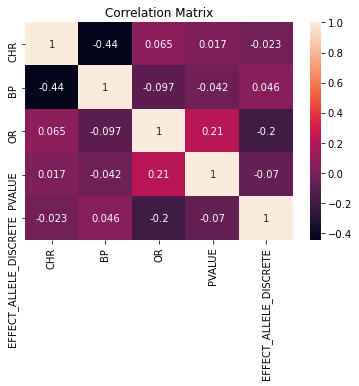

In [3]:
subset_numeric_list = ["CHR", "BP", "OR", "PVALUE", "EFFECT_ALLELE_DISCRETE"]

corr_matrix = all_few_missing[subset_numeric_list].corr()
sns.heatmap(corr_matrix, annot = True)
plt.title("Correlation Matrix")
plt.show()

Next, I compared the average values per trait. One interesting column is the odds ratio (OR) column. All traits have an odds ratio between 1-3, but mostly between 1-2. However, one trait has an odds ratio of ~7.5, indicating that its associated SNPs are "extremely damaging" (significantly larger than 1) and they cause individuals to have the trait. This table also suggests that chromosome may impact the associations (even though the correlation value between chr and pvalue was low). The average chromosome should be somewhere between 11-13, but there are only 4 traits in this range.

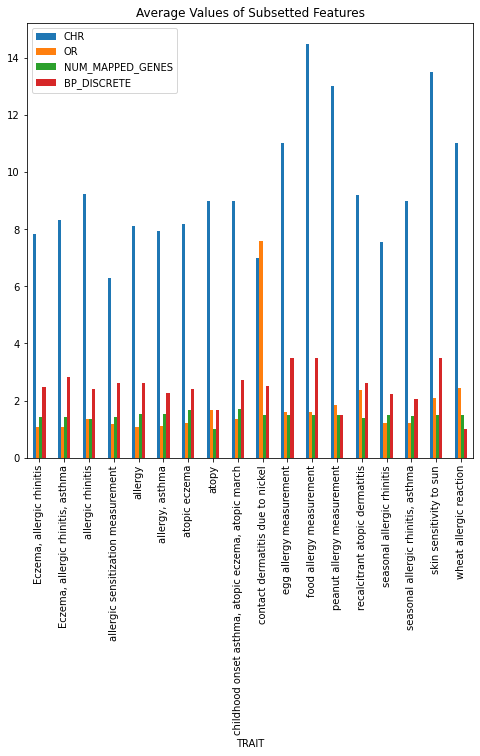

In [4]:
# Plotted features chosen so that we can see all of them on the graph (since the ranges are very different)
all_few_missing.groupby(by="TRAIT").mean().reset_index().plot("TRAIT", ["CHR", "OR", "NUM_MAPPED_GENES", 
                                                                        "BP_DISCRETE"], 
                                                              kind="bar", figsize = (8,8))
plt.title("Average Values of Subsetted Features")
plt.show()

Next, I analyzed the SNP association distribution per trait. This was skewed as some traits had ~300 associations while others had ~3. I have plotted the top traits as there are several with <10 associations which makes the plot illegible. This discrepancy is a source of confounding. In my analysis, I plan to compare traits with a similar amount of associations. When generating models, I will have to be careful to account for overfitting it I incorporate the traits with a small number of associations. I have include the association counts for all traits in the Appendix.

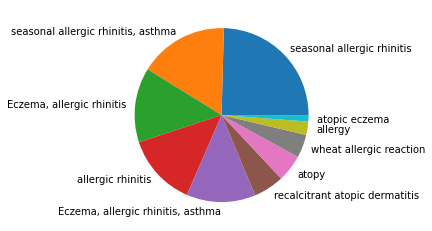

In [5]:
# Pie chart excluding the lowest 8 traits to make it legible
plt.pie(all_few_missing["TRAIT"].value_counts()[:-8], labels = all_few_missing["TRAIT"].unique()[:-8])
plt.show()

Prior to analyzing the dataset, I was interested in identifying features that could be used to determine if a SNP is associated with a specific trait. I wasn't entirely sure what the distributions of these features would look like, but assumed they'd be approximately normal. That was the case for several of the features, but there were a few that were more right skewed. I have plotted those two features below: chromosome and base pair. These plots indicate that there are many more associations at lower chromosomes and at smaller base pairs. I plan to look into this some more to identify possible reasons for this or if it's just a result of a biased dataset.

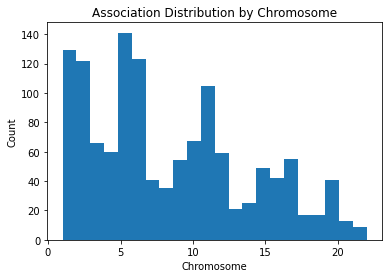

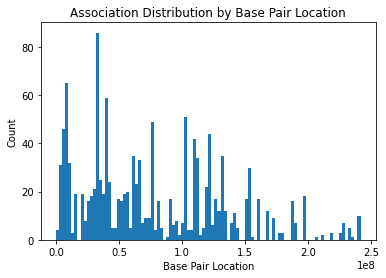

In [6]:
plt.hist(all_few_missing["CHR"], bins = 22)
plt.xlabel("Chromosome")
plt.ylabel("Count")
plt.title("Association Distribution by Chromosome")
plt.show()

plt.hist(all_few_missing["BP"], bins = 100)
plt.xlabel("Base Pair Location")
plt.ylabel("Count")
plt.title("Association Distribution by Base Pair Location")
plt.show()

Next, I looked into different correlation tests. I had already analyzed the Pearson correlation values, so now I calculated the Kendall and Spearman correlation values. I noticed differenes ranging up to 0.2, but I don't believe this is very significant and is expected since these tests perform the calculations differently. I don't plan to pursue this in my future analysis, but have included some of my findings in the Appendix.

Another question I was interested in was understanding if risk allele is associated phenotype. I compared the average risk allele per trait. I did notice some differences; however, I believe they were caused by limitations in the dataset. For example, some averages were pulled down because missing values were represented with -10. Also, the discrete levels ranges from 1-4, and I believe this range is too small given the number of samples in the dataset to make a well-informed decision. I've include the statistics in the Appendix, but I don't plan to pursue this relationship in my future analyses.

Next I subsetted the entire dataset based on specific traits and compared the statistics of those two features. I focused on allergic rhinitis and atopic eczema. I briefly mentioned by reasons in the previous data limitations section. I don't plan to compare the multi-phenotype traits since there is a lot of overlap. For example, I am hesitant to compare the "Eczema, allergic rhinitis" trait with the "Eczema, allergic rhinitis, asthma" trait, even though those two traits have the largest sample size. I don't believe I can control the sources of confounding well enough for those traits. Thus, I chose to analyze individual traits.

I analyzed the correlation matrices for these individual traits, and found stronger correlations for almost every pair of features. However, I didn't value this too much because I believe a reason for this is the small trait-specific sample size. Also, the correlations max increased by 0.2, which I don't believe is that significant, especially given the sample size. I also compared the average values of the features for these two traits, and expectedly identified some minor differences. Since I didn't find these results too surprising, I just included them in the Appendix.

Initially, I also wanted to aggregate all the SNPs into a single allergy phenotype and then compare individual phenotypes with this entire grouping to identify any underlying differences between specific phenotypes and generic allergic disease. For example, do the SNPs associated with allergic rhinitis tend to have a positive direction of effect while general allergy associations have a negative direction of effect? I used the previous two traits (allergic rhinitis and atopic eczema) and compared them to a generic allergy phenotype, which was represented by the entire dataset. So I compared a segment of the dataset (one trait) to the entire dataset (which included that trait).

I have plotted the _difference_ in correlations for a subset of interesting features. I calculated these by subtracting the original correlation matrices. I was surprised by the amount of deviation there was between the trait-specific plots and combined allergy phenotype. Even though the deviation doesn't seem that large, I expected it to be close to uniform since many of these phenotypes are related biologically. I have included the original three correlating matrices in the Appendix.

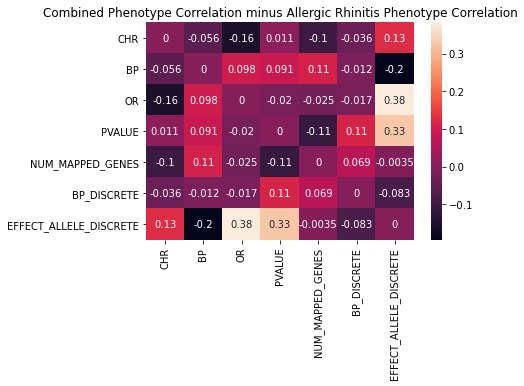

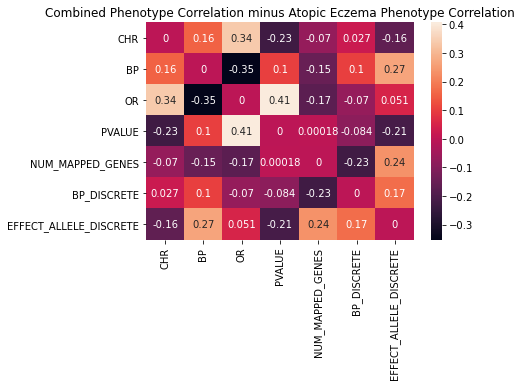

In [7]:
# Subset datasets
all_rhin = all_few_missing[ all_few_missing["TRAIT"] == "allergic rhinitis"].copy()
eczema = all_few_missing[ all_few_missing["TRAIT"] == "atopic eczema"].copy()
full_numeric_list = ["CHR", "BP", "OR", "PVALUE", "NUM_MAPPED_GENES", "BP_DISCRETE", "EFFECT_ALLELE_DISCRETE"]

corr_matrix = all_few_missing[full_numeric_list].corr()-all_rhin[full_numeric_list].corr()
sns.heatmap(corr_matrix, annot = True)
plt.title("Combined Phenotype Correlation minus Allergic Rhinitis Phenotype Correlation")
plt.show()

corr_matrix = all_few_missing[full_numeric_list].corr()-eczema[full_numeric_list].corr()
sns.heatmap(corr_matrix, annot = True)
plt.title("Combined Phenotype Correlation minus Atopic Eczema Phenotype Correlation")
plt.show()

Lastly, I compared the summary statistics, specifically the quartiles, of the combined phenotype with the two individual phenotypes (Allergic Rhinitis and Atopic Eczema). In general, the plots look fairly similar. I believe the slight differences can be attributed to the small sample size for Atopic Eczema. I have included these plots in the Appendix.

__Exploratory Data Analysis Summary__: My initial research questions included analyzing many features in the dataset. After performing an exploratory analysis, there are a few features that I plan to focus on. I will focus my analysis on the relationship between chromosome and base pair, along with the relationship between discrete effect allele and odds ratio. I also hope to understand the extent to which odds ratio and chromosomal location are factors in determining association with a trait of interest. I will mostly compare traits with similar sample sizes to avoid introducing extra sources of bias, but will compare the combined allergy phenotype with individual traits.

### Appendix

#### Data Collection

First, I scraped from the GWAS Catalog and create a dataframe with the results.

In [8]:
gwas_catalog = pd.read_json("https://www.ebi.ac.uk/gwas/summary-statistics/api/traits/EFO_0003785/associations")

# Subset the list of associations
associations = gwas_catalog["_embedded"]["associations"]

scraped_df = pd.DataFrame(columns = ["BETA", "CHR", "BP", "OR", "RAF", "PVALUE", "VARIANT", "EFFECT_ALLELE", 
                                     "TRAIT", "MAPPED_GENE_LIST", "NUM_MAPPED_GENES", "TRAITS_ASSOCIATED_WITH_MAPPED_GENES"])

for i in range(len(associations)):
    obj = associations[str(i)] # Association object
    
    # Obtain all the info I need
    beta = obj["beta"]
    chrom = obj["chromosome"]
    bp = obj["base_pair_location"]
    odd_rat = obj["odds_ratio"]
    eff_allele_freq = obj["effect_allele_frequency"]
    p_val = obj["p_value"]
    variant = obj["variant_id"]
    eff_allele = obj["effect_allele"]
    trait = "Atopy"
    
    # Create new row and add it to the dataframe
    scraped_df.loc[len(scraped_df)] = [beta, chrom, bp, odd_rat, eff_allele_freq, p_val, variant, eff_allele, trait, [], 0, "-"]

Next, I read all the data from the csv files and added them all to one dataframe. Summary statistics were downloaded from the NHGRI-EBI GWAS Catalog on 09/27/2020.

In [9]:
trait_files = ["data/all-rhin-associations-2020-09-27.csv", "data/all-allergy-associations-2020-09-28.csv"]
additional_trait_codes = ["0000274", "0002686", "0003956", "0005298", "0007016", 
                          "0007017", "0007018", "0007019", "1000651", "1001243"]

for val in additional_trait_codes:
    new_file = "data/efotraits_EFO_" + val + "-associations-2020-09-30.csv" # assemble file name
    trait_files.append(new_file)

# Create a dataframe will the data from all the csv files
all_traits = pd.read_csv(trait_files[0])
for file in trait_files[1:]:
    new_trait = pd.read_csv(file)
    all_traits = all_traits.append(new_trait, ignore_index = True)

Next, I processed the aggregated dataframe from all the csv files. 

I split the variant and risk allele column into two columns so that I can process both separately. When loading the original column as a dataframe the HTML b tag was read as a string so I used the string version of the tag as a delimeter.

Then, I split the location column into two columns (chromosome and base pair location). This time I used a colon as the delimeter.

Then, I converted the mapped gene column to a list and to help calculate the number of mapped genes.

Then, I added another column that contains traits associated with the same mapped genes.

In [10]:
# SNP and risk allele
all_traits["VARIANT"] = [i.split("-<b>")[0] for i in all_traits["Variant and risk allele"]]
all_traits["EFFECT_ALLELE"] = [i.split("-<b>")[1][0] for i in all_traits["Variant and risk allele"]]

# Chromosome and base pair
all_traits["CHR"] = [i.split(":")[0] for i in all_traits["Location"]]
all_traits["BP"] = [i.split(":")[1] if len(i.split(":")) > 1 else i.split(":")[0] for i in all_traits["Location"]]

# Gene List
all_traits["MAPPED_GENE_LIST"] = [ i.split(", ") for i in all_traits["Mapped gene"] ]
all_traits["NUM_MAPPED_GENES"] = [ len(i.split(", ")) for i in all_traits["Mapped gene"] ]

In [11]:
food_allergy = pd.read_csv("data/food allergy-DOID_3044-genes-2020-09-27.tsv", sep = "\t") # Read in gene data

gene_disease_dict = {} # Dictionary containing genes and corresponding associated traits
for val in food_allergy[["Gene Symbol", "Disease Name"]].itertuples():
    gene_disease_dict[val[1]] = val[2]

prev_associated_traits = []
for gene_list in all_traits["MAPPED_GENE_LIST"]:
    prev_trait_list = [] # Use a list in case there are multiple previous associations
    for gene in gene_disease_dict:
        if gene in gene_list:
            prev_trait_list.append(gene_disease_dict[gene]) # Add the previously associated disease
            
    # Represent no previous associations using a hypen instead of an empty list
    if prev_trait_list == []:
        prev_trait_list = "-"
    
    prev_associated_traits.append(prev_trait_list)

all_traits["TRAITS_ASSOCIATED_WITH_MAPPED_GENES"] = prev_associated_traits

Finally, I merged the web scraped dataframe and the csv aggregated dataframe.

In [12]:
# Add matching columns before merging them
all_traits["BETA"] = all_traits["Beta"]
all_traits["PVALUE"] = all_traits["P-value"]
all_traits["TRAIT"] = all_traits["Trait(s)"]
all_traits_subset = all_traits[["BETA", "CHR", "BP", "OR", "RAF", "PVALUE", "VARIANT", "EFFECT_ALLELE", "TRAIT", 
                                "MAPPED_GENE_LIST", "NUM_MAPPED_GENES", "TRAITS_ASSOCIATED_WITH_MAPPED_GENES"]]

all_traits_merged = all_traits_subset.append(scraped_df, ignore_index = True)

#### Data Cleaning

In [13]:
# BETA
all_traits_merged = all_traits_merged[all_traits_merged["BETA"].notna()] # Remove the NA BETA rows (only 20) for processing

new_beta_list = []
for val in all_traits_merged["BETA"]:
    sub_list = val.split(" ")
    if (len(sub_list) == 1):
        new_beta_list.append(-10) # Use -10 to represent missing values -- will not process these values
    elif (sub_list[2] == "increase"):
        new_beta_list.append(float(sub_list[0])) # leave increases as positive values
    else:
        new_beta_list.append(-1 * float(sub_list[0])) # add a negative to represent a decrease
all_traits_merged["BETA"] = new_beta_list

# RAF
new_raf_list = []
for val in all_traits_merged["RAF"]:
    if type(val) == float or type(val) == int:
        new_raf_list.append(val)
    elif val.isnumeric():
        new_raf_list.append(float(val))
    else:
        new_raf_list.append(-10)
all_traits_merged["RAF"] = new_raf_list

# PVALUE
new_pvalue_list = []
for val in all_traits_merged["PVALUE"]:
    temp = val.split(" ")
    first = float(temp[0])
    exponent = float(temp[2].split("-")[1])
    out = first * 10 ** (-1 * exponent)
    new_pvalue_list.append(out)
all_traits_merged["PVALUE"] = new_pvalue_list

# EFFECT ALLELE
all_traits_merged = all_traits_merged[ all_traits_merged["EFFECT_ALLELE"] != "D" ] # Remove invalid entries

# CHR, BP, and OR
# Convert other values to numbers, if NA set to -10
all_traits_merged["CHR"] = [ float(i) if i.isnumeric() else -10 for i in all_traits_merged["CHR"] ]
all_traits_merged["BP"] = [ float(i) if i.isnumeric() else -10 for i in all_traits_merged["BP"] ]
all_traits_merged["OR"] = [ float(i) if i != "'-" else -10 for i in all_traits_merged["OR"] ]

In [14]:
# BP
# Map chromosome to total number of base pairs
total_base_pair = {1: 240e6, 2: 240e6, 3: 200e6, 4: 190e6, 5: 180e6, 6: 170e6, 7: 150e6, 8: 140e6, 9: 130e6, 
                   10: 130e6, 11: 130e6, 12: 130e6, 13: 110e6, 14: 100e6, 15: 100e6, 16: 90e6, 17: 80e6,
                   18: 70e6, 19: 60e6, 20: 60e6, 21: 40e6, 22: 40e6}

new_bp_list = []
for num in range(all_traits_merged.shape[0]):
    row = all_traits_merged.iloc[num]
    chrom = row["CHR"]
    bp = row["BP"]
    
    # Assign discrete value based on quartile
    if (chrom == -10 or bp == -10):
        new_bp_list.append(-10)
    elif (bp < (0.25 * total_base_pair[chrom])):
        new_bp_list.append(1)
    elif (bp < (0.50 * total_base_pair[chrom]) and (bp >= (0.25 * total_base_pair[chrom]))):
        new_bp_list.append(2)
    elif (bp < (0.75 * total_base_pair[chrom]) and (bp >= (0.50 * total_base_pair[chrom]))):
        new_bp_list.append(3)
    else:
        new_bp_list.append(4)

all_traits_merged["BP_DISCRETE"] = new_bp_list

# EFFECT ALLELE
# Map allel to discrete value
effect_allele = {"T": 1, "A": 2, "G": 3, "C": 4, "?": -10}

new_effect_allele_list = []
for val in all_traits_merged["EFFECT_ALLELE"]:
    new_effect_allele_list.append(effect_allele[val])

all_traits_merged["EFFECT_ALLELE_DISCRETE"] = new_effect_allele_list

Here is the cleaned final dataset.

In [15]:
all_traits_merged

BETA   CHR           BP     OR     RAF        PVALUE     VARIANT  \
0    -10.0  11.0   76588150.0  1.220 -10.000  1.000000e-08   rs2155219   
1    -10.0   5.0  110810746.0  1.390 -10.000  1.000000e-08  rs17513503   
2    -10.0   4.0  122451978.0  1.190 -10.000  1.000000e-06   rs2069772   
3    -10.0  16.0    9305867.0  1.180 -10.000  2.000000e-06    rs631208   
4    -10.0   1.0   51393570.0  1.350 -10.000  2.000000e-06   rs6673480   
...    ...   ...          ...    ...     ...           ...         ...   
1542 -10.0  10.0    8981852.0  1.946   0.580  1.000000e-07  rs35766269   
1543 -10.0  13.0   64989899.0  2.655   0.083  1.000000e-08   rs9540294   
1544 -10.0  15.0   76812515.0  2.126   0.137  3.000000e-07   rs3099143   
1545 -10.0   6.0   32623176.0  2.300   0.523  1.000000e-26   rs9271588   
1546 -10.0  16.0    7706047.0  2.570   0.024  1.000000e-08  rs59325236   

     EFFECT_ALLELE                           TRAIT         MAPPED_GENE_LIST  \
0                T      seasonal allergic rhinitis       [EMSY, AP001189.2]   
1                G      seasonal allergic rhinitis   [SLC25A46, AC008782.1]   
2                C      seasonal allergic rhinitis                    [IL2]   
3                A      seasonal allergic rhinitis   [LINC02177, RPL21P119]   
4                T      seasonal allergic rhinitis                  [EPS15]   
...            ...                             ...                      ...   
1542             A  recalcitrant atopic dermatitis  [LINC00709, AC044784.1]   
1543             G  recalcitrant atopic dermatitis         [STARP1, LGMNP1]   
1544             C  recalcitrant atopic dermatitis                 [SCAPER]   
1545             G         wheat allergic reaction     [HLA-DQA1, HLA-DRB1]   
1546             A         wheat allergic reaction                 [RBFOX1]   

     NUM_MAPPED_GENES TRAITS_ASSOCIATED_WITH_MAPPED_GENES  BP_DISCRETE  \
0                   2                                   -            3   
1                   2                                   -            3   
2                   1                                   -            3   
3                   2                                   -            1   
4                   1                                   -            1   
...               ...                                 ...          ...   
1542                2                                   -            1   
1543                2                                   -            3   
1544                1                                   -            4   
1545                2                                   -            1   
1546                1                                   -            1   

      EFFECT_ALLELE_DISCRETE  
0                          1  
1                          3  
2                          4  
3                          2  
4                          1  
...                      ...  
1542                       2  
1543                       3  
1544                       4  
1545                       3  
1546                       2  

[1543 rows x 14 columns]

Finally, I saved the dataset as a csv.

In [16]:
all_traits_merged.to_csv("final_dataset.csv", index = False)

#### Exploratory Analysis

In [17]:
full_numeric_list = ["CHR", "BP", "OR", "PVALUE", "NUM_MAPPED_GENES", "BP_DISCRETE", "EFFECT_ALLELE_DISCRETE"]
for val1 in full_numeric_list:
    for val2 in full_numeric_list:
        if (val1 != val2):
            print("First Feature: {}, Second Feature: {}, Correlation: {:.4f}".format(val1, val2, all_few_missing[val1].corr(all_few_missing[val2])))

First Feature: CHR, Second Feature: BP, Correlation: -0.4448
First Feature: CHR, Second Feature: OR, Correlation: 0.0650
First Feature: CHR, Second Feature: PVALUE, Correlation: 0.0166
First Feature: CHR, Second Feature: NUM_MAPPED_GENES, Correlation: -0.0047
First Feature: CHR, Second Feature: BP_DISCRETE, Correlation: 0.1453
First Feature: CHR, Second Feature: EFFECT_ALLELE_DISCRETE, Correlation: -0.0231
First Feature: BP, Second Feature: CHR, Correlation: -0.4448
First Feature: BP, Second Feature: OR, Correlation: -0.0972
First Feature: BP, Second Feature: PVALUE, Correlation: -0.0423
First Feature: BP, Second Feature: NUM_MAPPED_GENES, Correlation: 0.0059
First Feature: BP, Second Feature: BP_DISCRETE, Correlation: 0.7450
First Feature: BP, Second Feature: EFFECT_ALLELE_DISCRETE, Correlation: 0.0459
First Feature: OR, Second Feature: CHR, Correlation: 0.0650
First Feature: OR, Second Feature: BP, Correlation: -0.0972
First Feature: OR, Second Feature: PVALUE, Correlation: 0.2144
Fi

In [18]:
all_few_missing["TRAIT"].value_counts()

Eczema, allergic rhinitis                              308
allergic rhinitis                                      208
atopic eczema                                          174
Eczema, allergic rhinitis, asthma                      168
allergy                                                161
allergy, asthma                                         71
seasonal allergic rhinitis, asthma                      63
seasonal allergic rhinitis                              54
allergic sensitization measurement                      31
recalcitrant atopic dermatitis                          15
childhood onset asthma, atopic eczema, atopic march     14
atopy                                                    6
egg allergy measurement                                  4
peanut allergy measurement                               4
wheat allergic reaction                                  4
food allergy measurement                                 2
skin sensitivity to sun                                 

In [19]:
print("Pearson Correlation:", all_few_missing["NUM_MAPPED_GENES"].corr(all_few_missing["PVALUE"]))
print("Kendall Correlation:", all_few_missing["NUM_MAPPED_GENES"].corr(all_few_missing["PVALUE"], method = "kendall"))
print("Spearman Correlation:", all_few_missing["NUM_MAPPED_GENES"].corr(all_few_missing["PVALUE"], method = "spearman"))

Pearson Correlation: -0.02909844377773101
Kendall Correlation: -0.1079679402681152
Spearman Correlation: -0.13184179954652772


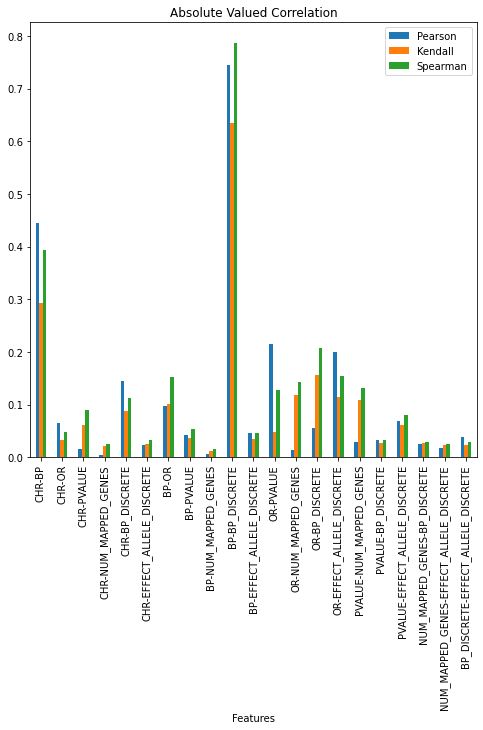

In [20]:
# Pearson correlation measures the relationship between linearly related variables
# Kendall rank correlation measures the strength of dependence between two variables
# Spearman rank correlation measures the degree of association between two variables

correlation_list = ["CHR", "BP", "OR", "PVALUE", "NUM_MAPPED_GENES", "BP_DISCRETE", "EFFECT_ALLELE_DISCRETE"]
correlation_df = pd.DataFrame(columns = ["Features", "Pearson", "Kendall", "Spearman"])

feature_pairs = [] # Use this to exclude duplicates with the features flipped

for feature1 in correlation_list:
    for feature2 in correlation_list:
        features = feature1 + "-" + feature2
        # Don't calculate feature correlation with itself or duplicate calculations
        if (feature1 != feature2 and features not in feature_pairs):
            col1 = all_few_missing[feature1]
            col2 = all_few_missing[feature2]
            
            # Add absolute value so it is easier to compare different parts of the plot
            correlation_df.loc[len(correlation_df)] = [features, abs(col1.corr(col2)), 
                                                       abs(col1.corr(col2, method = "kendall")), 
                                                       abs(col1.corr(col2, method = "spearman"))]
        feature_pairs.append(feature1 + "-" + feature2)
        feature_pairs.append(feature2 + "-" + feature1)

correlation_df.plot("Features", ["Pearson", "Kendall", "Spearman"], kind="bar", figsize = (8,8))
plt.title("Absolute Valued Correlation")
plt.show()

In [21]:
all_few_missing.groupby(by="TRAIT").mean()["EFFECT_ALLELE_DISCRETE"]

TRAIT
Eczema, allergic rhinitis                               2.655844
Eczema, allergic rhinitis, asthma                       2.130952
allergic rhinitis                                      -2.038462
allergic sensitization measurement                      1.774194
allergy                                                 0.621118
allergy, asthma                                       -10.000000
atopic eczema                                           1.574713
atopy                                                  -1.000000
childhood onset asthma, atopic eczema, atopic march     3.000000
contact dermatitis due to nickel                        3.000000
egg allergy measurement                                 2.500000
food allergy measurement                                2.000000
peanut allergy measurement                              4.000000
recalcitrant atopic dermatitis                          3.400000
seasonal allergic rhinitis                              2.555556
seasonal allergic r

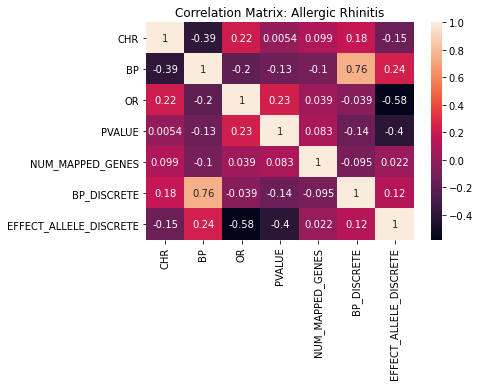

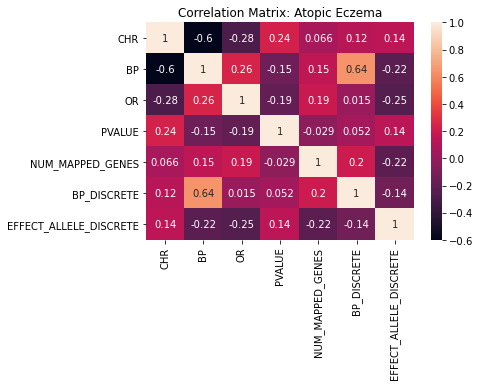

In [22]:
# Compare specific traits
full_numeric_list = ["CHR", "BP", "OR", "PVALUE", "NUM_MAPPED_GENES", "BP_DISCRETE", "EFFECT_ALLELE_DISCRETE"]
corr_matrix = all_rhin[full_numeric_list].corr()
sns.heatmap(corr_matrix, annot = True)
plt.title("Correlation Matrix: Allergic Rhinitis")
plt.show()

corr_matrix = eczema[full_numeric_list].corr()
sns.heatmap(corr_matrix, annot = True)
plt.title("Correlation Matrix: Atopic Eczema")
plt.show()

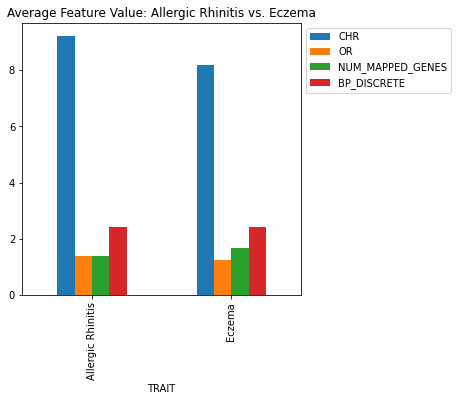

In [23]:
# Compare the mean values of these features for the two traits

# Exclude BP and PVALUE for scaling - to use the same scale on the plots
feature_list = ["CHR", "OR", "NUM_MAPPED_GENES", "BP_DISCRETE"]
all_rhin_mean = ["Allergic Rhinitis"]
eczema_mean = ["Eczema"]

for feature in feature_list:
    all_rhin_mean.append(all_rhin[feature].mean())
    eczema_mean.append(eczema[feature].mean())

average_df = pd.DataFrame(columns = ["TRAIT", "CHR", "OR", "NUM_MAPPED_GENES", "BP_DISCRETE"])

average_df.loc[0] = all_rhin_mean
average_df.loc[1] = eczema_mean

average_df.plot("TRAIT", ["CHR", "OR", "NUM_MAPPED_GENES", "BP_DISCRETE"], kind="bar", figsize = (5,5))
plt.title("Average Feature Value: Allergic Rhinitis vs. Eczema")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

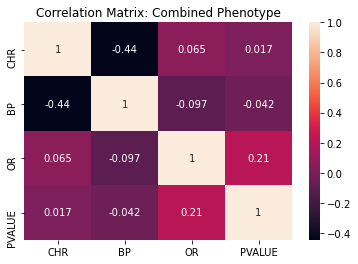

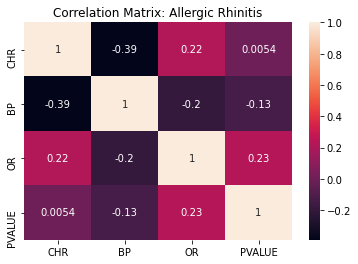

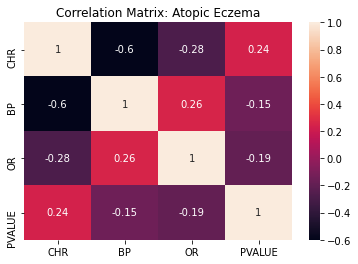

In [24]:
# Use the previous two traits and compare their statistics with the entire dataframe's statistics
full_numeric_list = ["CHR", "BP", "OR", "PVALUE"]
matrix_type = ["Combined Phenotype", "Allergic Rhinitis", "Atopic Eczema"]
count = 0

for df in [all_few_missing, all_rhin, eczema]:
    corr_matrix = df[full_numeric_list].corr()
    sns.heatmap(corr_matrix, annot = True)
    plt.title("Correlation Matrix: " + matrix_type[count])
    plt.show()
    count += 1

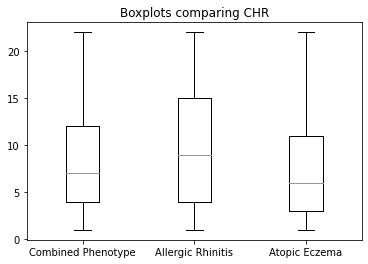

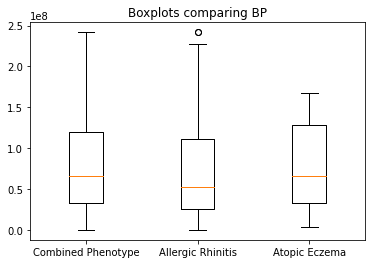

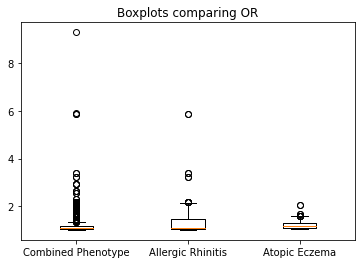

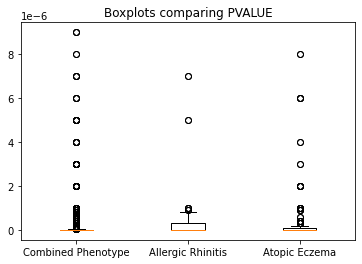

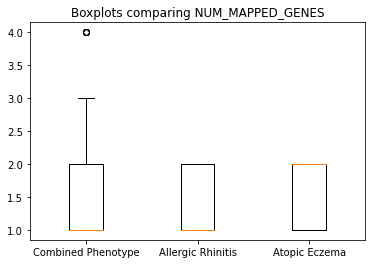

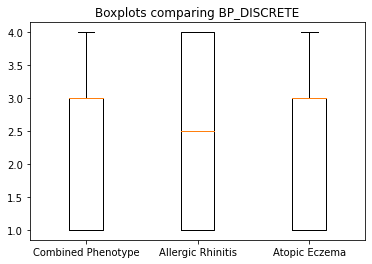

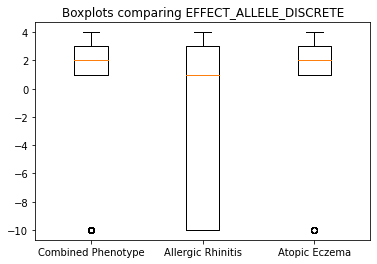

In [25]:
# Generate box plots comparing the two individual phenotypes and the combined allergy phenotype
full_numeric_list = ["CHR", "BP", "OR", "PVALUE", "NUM_MAPPED_GENES", "BP_DISCRETE", "EFFECT_ALLELE_DISCRETE"]

for feature in full_numeric_list:
    fig, ax = plt.subplots()
    ax.boxplot([all_few_missing[feature], all_rhin[feature], eczema[feature]])
    plt.title("Boxplots comparing " + feature)
    plt.xticks([1, 2, 3], ["Combined Phenotype", "Allergic Rhinitis", "Atopic Eczema"])
    plt.show()